In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
import decoupler as dc
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
from scipy import stats
import squidpy as sq
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

import NaiveDE
import SpatialDE

In [2]:
adata_ko = ad.read('/group/neur6/jupyterlab/adata_ko_raw.h5ad')
adata_hetero = ad.read('/group/neur6/jupyterlab/adata_hetero_raw.h5ad')
adata_ctrl = ad.read('/group/neur6/jupyterlab//adata_ctrl_raw.h5ad')

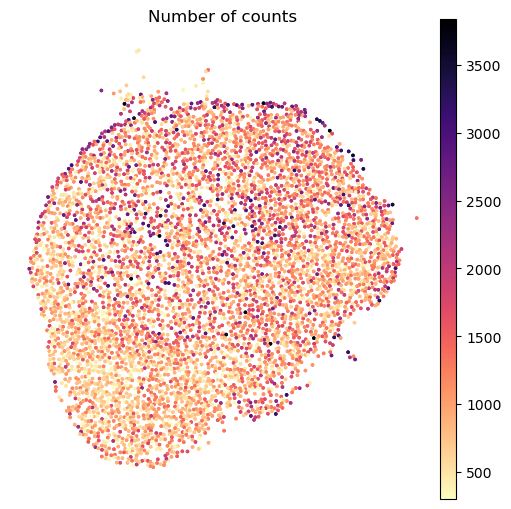

In [3]:
sq.pl.spatial_scatter(
    adata_ctrl,
    size=10, library_id="spatial", figsize=(5, 5),cmap='magma_r',ncols=2,frameon=False,shape=None,
    color=["nCount_Spatial"],title=['Number of counts']
)
plt.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/FiFIG3_B.pdf',dpi=300)


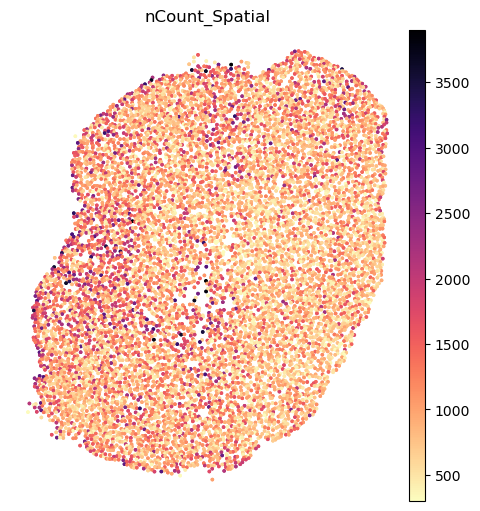

In [13]:
sq.pl.spatial_scatter(
    adata_hetero,
    size=10, library_id="spatial", figsize=(5, 5),cmap='magma_r',ncols=2,frameon=False,shape=None,
    color=["nCount_Spatial"]
)

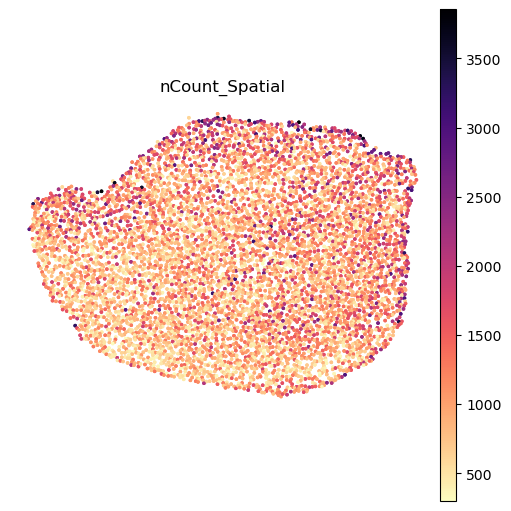

In [14]:
sq.pl.spatial_scatter(
    adata_ko,
    size=10, library_id="spatial", figsize=(5, 5),cmap='magma_r',ncols=2,frameon=False,shape=None,
    color=["nCount_Spatial"]
)

In [5]:
from matplotlib.legend import Legend 

Number of far points identified: 546
Number of KNN outliers identified among far points: 13


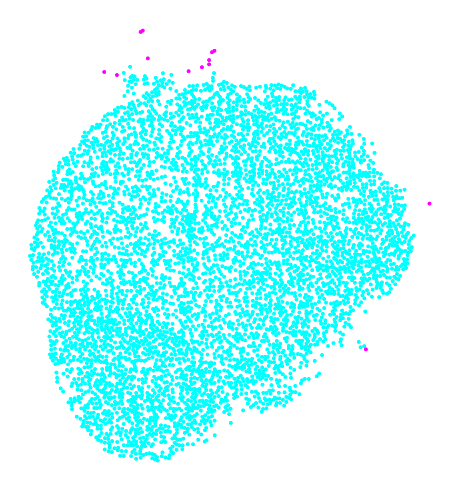

In [8]:
# Calculate the centroid of the points
centroid_x = adata_ctrl.obs['x'].mean()
centroid_y = adata_ctrl.obs['y'].mean()

# Calculate the Euclidean distance of each point to the centroid
adata_ctrl.obs['distance_to_centroid'] = np.sqrt(
    (adata_ctrl.obs['x'] - centroid_x) ** 2 + (adata_ctrl.obs['y'] - centroid_y) ** 2
)

# Identify far points based on a threshold (e.g., beyond a certain percentile)
distance_threshold = adata_ctrl.obs['distance_to_centroid'].quantile(0.9)  # Adjust percentile as needed
far_points = adata_ctrl.obs['distance_to_centroid'] > distance_threshold
adata_ctrl.obs['far_points'] = far_points

# Optionally, print the number of far points identified
print(f"Number of far points identified: {far_points.sum()}")

# Indices and coordinates of points farther from the centroid
far_point_indices = adata_ctrl.obs[adata_ctrl.obs['far_points']].index
far_point_coordinates = adata_ctrl.obs.loc[far_point_indices, ['x', 'y']].values

# Use all coordinates to find neighbors
all_coordinates = adata_ctrl.obs[['x', 'y']].values

# Set the number of neighbors (k)
k = 10  # Adjust k based on your data

# Compute the k nearest neighbors for far points
nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(all_coordinates)
distances, indices = nbrs.kneighbors(far_point_coordinates)

# Exclude the first column (distance to itself)
neighbor_distances = distances[:, 1:]

# Calculate the average distance to the k nearest neighbors
avg_neighbor_distance = neighbor_distances.mean(axis=1)
adata_ctrl.obs.loc[far_point_indices, 'avg_neighbor_distance'] = avg_neighbor_distance

# Calculate the Z-score of the average neighbor distances for the far points
z_scores = stats.zscore(avg_neighbor_distance)
adata_ctrl.obs.loc[far_point_indices, 'neighbor_distance_zscore'] = z_scores

# Define a threshold for outliers (e.g., Z-score > 3)
z_threshold = 2 # Adjust as needed

# Identify outliers among the far points
is_outlier_knn = z_scores > z_threshold

# Initialize 'is_outlier' column in adata_ctrl.obs if not already done
if 'is_outlier' not in adata_ctrl.obs.columns:
    adata_ctrl.obs['is_outlier'] = False

# Assign outlier status to the far points
adata_ctrl.obs.loc[far_point_indices, 'is_outlier'] = is_outlier_knn

# Number of KNN outliers among the far points
print(f"Number of KNN outliers identified among far points: {is_outlier_knn.sum()}")



sq.pl.spatial_scatter(
    adata_ctrl,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    cmap='cool',
    ncols=2,
    frameon=False,
    shape=None,
    color=[ "is_outlier"],title=''
)
# Get the current figure
fig = plt.gcf()

# Remove the legend
for ax in fig.get_axes():
    for obj in ax.get_children():
        if isinstance(obj, Legend):
            obj.remove()

# **Manually Find and Remove the Colorbar**
for ax in fig.axes:
    if "colorbar" in str(ax):  # Check if this is the colorbar axis
        fig.delaxes(ax)

# **Second Attempt: Remove Extra Axes (Colorbars are usually last axes added)**
while len(fig.axes) > 1:  # Assuming 1 main plot, remove extras
    fig.delaxes(fig.axes[-1])  # Delete last added axis (likely colorbar)

plt.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics_final/FIG3_C.pdf',dpi=300)
plt.show()


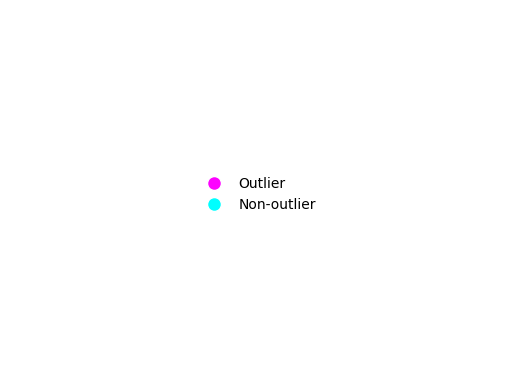

In [7]:
import matplotlib.pyplot as plt

def create_custom_legend(labels, colors, filename="legend.svg", dpi=300):
    fig, ax = plt.subplots()
    ax.axis("off")  # Hide axes

    # Create legend handles
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
               for color in colors]

    # Add legend
    legend = ax.legend(handles, labels, loc="center", frameon=False)

    # Save figure with tight bounding box to remove excess whitespace
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent=True)

    plt.show()

# Example usage
labels = ["Outlier","Non-outlier"]
colors = ['#fd02ff','#00ffff']

create_custom_legend(labels, colors, filename="/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics_final/FIG3_C_legend.pdf")


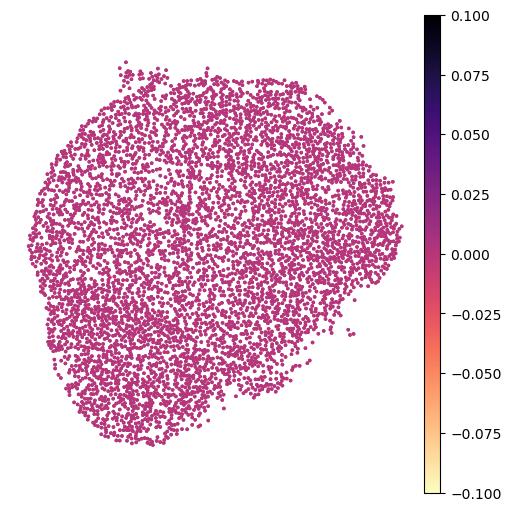

In [10]:

# Keep only the non-outlier points
adata_filtered_ctrl = adata_ctrl[adata_ctrl.obs['is_outlier'] == False].copy()

sq.pl.spatial_scatter(
    adata_filtered_ctrl,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    cmap='magma_r',
    ncols=2,
    frameon=False,
    shape=None,
    color=["is_outlier"],title=''
)
#plt.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics/fig3b.svg',dpi=300)


/group/neur6/singularity_imgs/.conda/envs/scvi-new/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


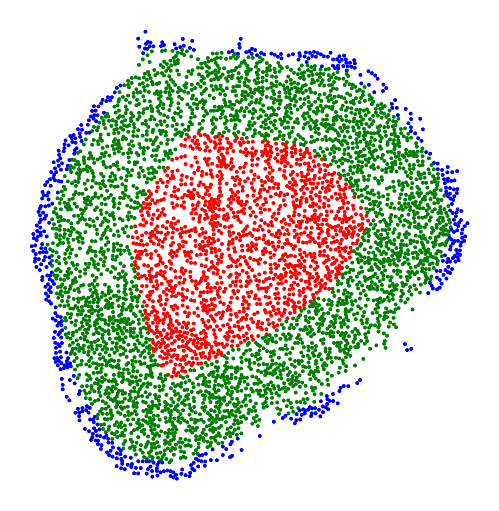

In [14]:

# Get the spatial coordinates as an array
points = adata_filtered_ctrl.obsm['spatial']

# Compute the convex hull
hull = ConvexHull(points)

# Extract the vertices of the convex hull
hull_points = points[hull.vertices]

# Create a shapely polygon from the convex hull points
hull_polygon = Polygon(hull_points)

from shapely.geometry import Point

# Function to compute distance from point to polygon boundary
def compute_distance_to_boundary(row, polygon):
    point = Point(row['x'], row['y'])
    distance = point.distance(polygon.boundary)
    return distance

# Apply the function to all spots
adata_filtered_ctrl.obs['distance_to_boundary'] = adata_filtered_ctrl.obs.apply(
    compute_distance_to_boundary,
    polygon=hull_polygon,
    axis=1
)

# Define thresholds
edge_threshold = adata_filtered_ctrl.obs['distance_to_boundary'].quantile(0.1)
max_distance = adata_filtered_ctrl.obs['distance_to_boundary'].max()
border_distance = max_distance / 2  # Adjust the fraction as needed

# Classify regions
def classify_region(distance, edge_threshold, border_distance):
    if distance <= edge_threshold:
        return 'edge'
    elif distance <= border_distance:
        return 'border'
    else:
        return 'core'

adata_filtered_ctrl.obs['region'] = adata_filtered_ctrl.obs['distance_to_boundary'].apply(
    classify_region, args=(edge_threshold, border_distance)
)

# Ensure 'region' is a categorical column
adata_filtered_ctrl.obs['region'] = adata_filtered_ctrl.obs['region'].astype('category')

# Define the colors corresponding to the categories
region_colors = ['green', 'red', 'blue']  # Adjust colors as needed

# Assign the colors to `adata_filtered_ctrl.uns`
adata_filtered_ctrl.uns['region_colors'] = region_colors

sq.pl.spatial_scatter(
    adata_filtered_ctrl,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=["region"],title=''
)
# Get the current figure
fig = plt.gcf()

# Remove the legend
for ax in fig.get_axes():
    for obj in ax.get_children():
        if isinstance(obj, Legend):
            obj.remove()

# **Manually Find and Remove the Colorbar**
for ax in fig.axes:
    if "colorbar" in str(ax):  # Check if this is the colorbar axis
        fig.delaxes(ax)

# **Second Attempt: Remove Extra Axes (Colorbars are usually last axes added)**
while len(fig.axes) > 1:  # Assuming 1 main plot, remove extras
    fig.delaxes(fig.axes[-1])  # Delete last added axis (likely colorbar)

plt.savefig('/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics_final/Fig3_D_classificRegions.pdf',dpi=300)

# Save the filtered dataset
#adata_filtered_ctrl.write('r1_ctrl_subset.h5ad')


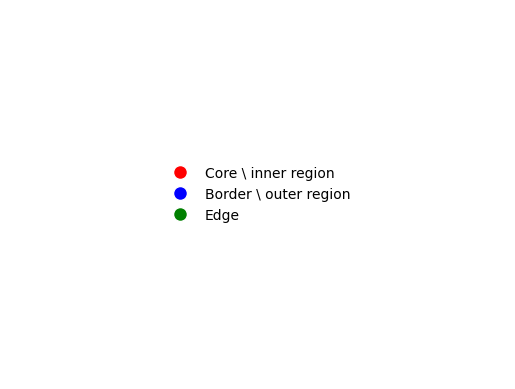

In [13]:
import matplotlib.pyplot as plt

def create_custom_legend(labels, colors, filename="legend.svg", dpi=300):
    fig, ax = plt.subplots()
    ax.axis("off")  # Hide axes

    # Create legend handles
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
               for color in colors]

    # Add legend
    legend = ax.legend(handles, labels, loc="center", frameon=False)

    # Save figure with tight bounding box to remove excess whitespace
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent=True)

    plt.show()

# Example usage
labels = ["Core \ inner region", "Border \ outer region", "Edge"]
colors = ["red", "blue", "green"]

create_custom_legend(labels, colors, filename="/group/tran3/mnucera/STOmics_crossorganoid_project/STOmics_notebooks/figures_stomics_final/Fig3_D_legend.pdf")


# ==========================

Number of far points identified: 975
Number of KNN outliers identified among far points: 16


/group/neur6/singularity_imgs/.conda/envs/scvi-new/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


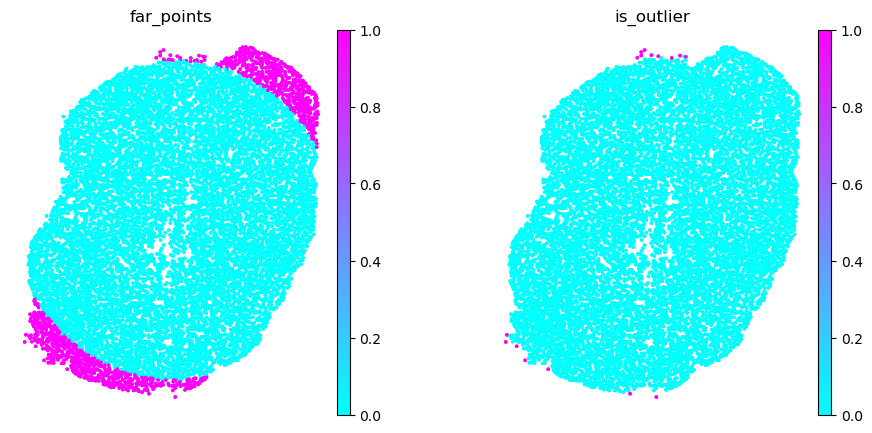

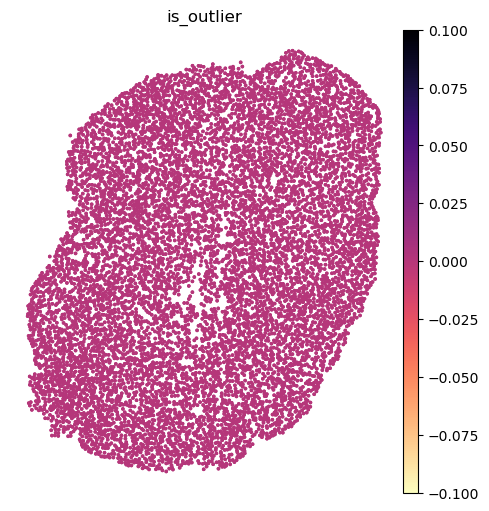

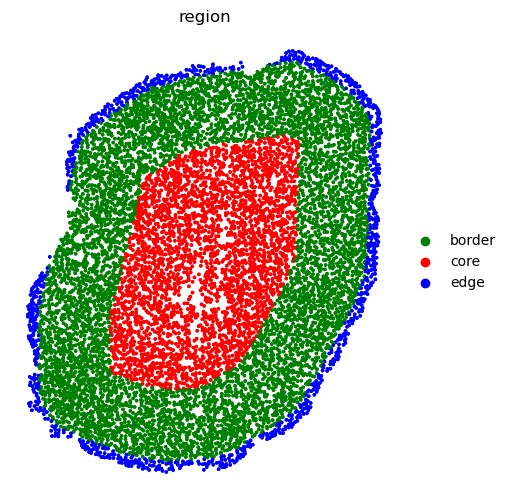

In [13]:
# Calculate the centroid of the points
centroid_x = adata_hetero.obs['x'].mean()
centroid_y = adata_hetero.obs['y'].mean()

# Calculate the Euclidean distance of each point to the centroid
adata_hetero.obs['distance_to_centroid'] = np.sqrt(
    (adata_hetero.obs['x'] - centroid_x) ** 2 + (adata_hetero.obs['y'] - centroid_y) ** 2
)

# Identify far points based on a threshold (e.g., beyond a certain percentile)
distance_threshold = adata_hetero.obs['distance_to_centroid'].quantile(0.9)  # Adjust percentile as needed
far_points = adata_hetero.obs['distance_to_centroid'] > distance_threshold
adata_hetero.obs['far_points'] = far_points

# Optionally, print the number of far points identified
print(f"Number of far points identified: {far_points.sum()}")

# Indices and coordinates of points farther from the centroid
far_point_indices = adata_hetero.obs[adata_hetero.obs['far_points']].index
far_point_coordinates = adata_hetero.obs.loc[far_point_indices, ['x', 'y']].values

# Use all coordinates to find neighbors
all_coordinates = adata_hetero.obs[['x', 'y']].values

# Set the number of neighbors (k)
k = 5  # Adjust k based on your data

# Compute the k nearest neighbors for far points
nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(all_coordinates)
distances, indices = nbrs.kneighbors(far_point_coordinates)

# Exclude the first column (distance to itself)
neighbor_distances = distances[:, 1:]

# Calculate the average distance to the k nearest neighbors
avg_neighbor_distance = neighbor_distances.mean(axis=1)
adata_hetero.obs.loc[far_point_indices, 'avg_neighbor_distance'] = avg_neighbor_distance

# Calculate the Z-score of the average neighbor distances for the far points
z_scores = stats.zscore(avg_neighbor_distance)
adata_hetero.obs.loc[far_point_indices, 'neighbor_distance_zscore'] = z_scores

# Define a threshold for outliers (e.g., Z-score > 3)
z_threshold = 3  # Adjust as needed

# Identify outliers among the far points
is_outlier_knn = z_scores > z_threshold

# Initialize 'is_outlier' column in adata_hetero.obs if not already done
if 'is_outlier' not in adata_hetero.obs.columns:
    adata_hetero.obs['is_outlier'] = False

# Assign outlier status to the far points
adata_hetero.obs.loc[far_point_indices, 'is_outlier'] = is_outlier_knn

# Number of KNN outliers among the far points
print(f"Number of KNN outliers identified among far points: {is_outlier_knn.sum()}")

# Visualize the far points and outliers
sq.pl.spatial_scatter(
    adata_hetero,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    cmap='cool',
    ncols=2,
    frameon=False,
    shape=None,
    color=["far_points", "is_outlier"]
)

# Keep only the non-outlier points
adata_filtered_hetero = adata_hetero[adata_hetero.obs['is_outlier'] == False].copy()

sq.pl.spatial_scatter(
    adata_filtered_hetero,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    cmap='magma_r',
    ncols=2,
    frameon=False,
    shape=None,
    color=["is_outlier"]
)

# Get the spatial coordinates as an array
points = adata_filtered_hetero.obsm['spatial']

# Compute the convex hull
hull = ConvexHull(points)

# Extract the vertices of the convex hull
hull_points = points[hull.vertices]

# Create a shapely polygon from the convex hull points
hull_polygon = Polygon(hull_points)

from shapely.geometry import Point

# Function to compute distance from point to polygon boundary
def compute_distance_to_boundary(row, polygon):
    point = Point(row['x'], row['y'])
    distance = point.distance(polygon.boundary)
    return distance

# Apply the function to all spots
adata_filtered_hetero.obs['distance_to_boundary'] = adata_filtered_hetero.obs.apply(
    compute_distance_to_boundary,
    polygon=hull_polygon,
    axis=1
)

# Define thresholds
edge_threshold = adata_filtered_hetero.obs['distance_to_boundary'].quantile(0.1)
max_distance = adata_filtered_hetero.obs['distance_to_boundary'].max()
border_distance = max_distance / 2  # Adjust the fraction as needed

# Classify regions
def classify_region(distance, edge_threshold, border_distance):
    if distance <= edge_threshold:
        return 'edge'
    elif distance <= border_distance:
        return 'border'
    else:
        return 'core'

adata_filtered_hetero.obs['region'] = adata_filtered_hetero.obs['distance_to_boundary'].apply(
    classify_region, args=(edge_threshold, border_distance)
)

# Ensure 'region' is a categorical column
adata_filtered_hetero.obs['region'] = adata_filtered_hetero.obs['region'].astype('category')

# Define the colors corresponding to the categories
region_colors = ['green', 'red', 'blue']  # Adjust colors as needed

# Assign the colors to `adata_filtered_hetero.uns`
adata_filtered_hetero.uns['region_colors'] = region_colors

sq.pl.spatial_scatter(
    adata_filtered_hetero,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=["region"]
)

# Save the filtered dataset
adata_filtered_hetero.write('r2_hetero_subset.h5ad')


Number of far points identified: 631
Number of KNN outliers identified among far points: 5


/group/neur6/singularity_imgs/.conda/envs/scvi-new/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


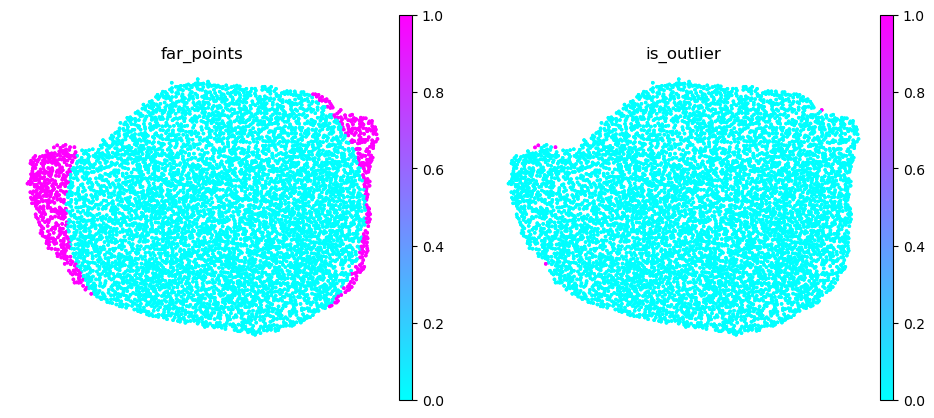

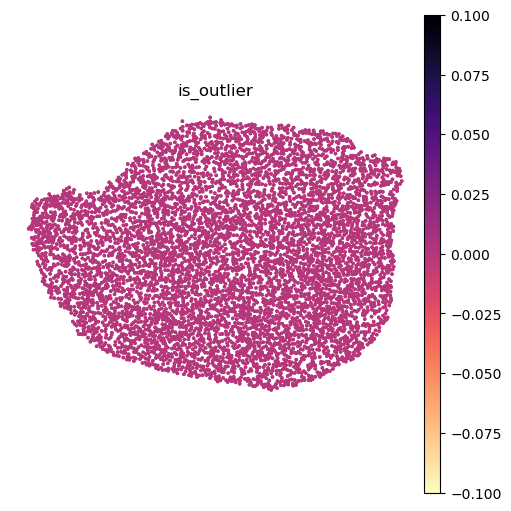

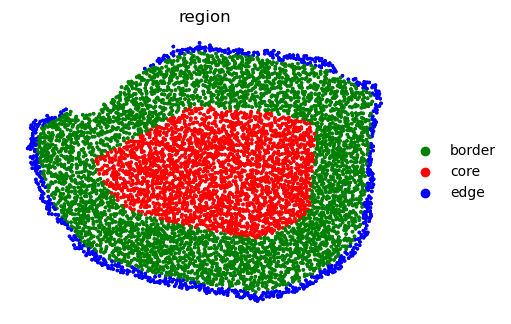

In [14]:
# Calculate the centroid of the points
centroid_x = adata_ko.obs['x'].mean()
centroid_y = adata_ko.obs['y'].mean()

# Calculate the Euclidean distance of each point to the centroid
adata_ko.obs['distance_to_centroid'] = np.sqrt(
    (adata_ko.obs['x'] - centroid_x) ** 2 + (adata_ko.obs['y'] - centroid_y) ** 2
)

# Identify far points based on a threshold (e.g., beyond a certain percentile)
distance_threshold = adata_ko.obs['distance_to_centroid'].quantile(0.9)  # Adjust percentile as needed
far_points = adata_ko.obs['distance_to_centroid'] > distance_threshold
adata_ko.obs['far_points'] = far_points

# Optionally, print the number of far points identified
print(f"Number of far points identified: {far_points.sum()}")

# Indices and coordinates of points farther from the centroid
far_point_indices = adata_ko.obs[adata_ko.obs['far_points']].index
far_point_coordinates = adata_ko.obs.loc[far_point_indices, ['x', 'y']].values

# Use all coordinates to find neighbors
all_coordinates = adata_ko.obs[['x', 'y']].values

# Set the number of neighbors (k)
k = 5  # Adjust k based on your data

# Compute the k nearest neighbors for far points
nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='ball_tree').fit(all_coordinates)
distances, indices = nbrs.kneighbors(far_point_coordinates)

# Exclude the first column (distance to itself)
neighbor_distances = distances[:, 1:]

# Calculate the average distance to the k nearest neighbors
avg_neighbor_distance = neighbor_distances.mean(axis=1)
adata_ko.obs.loc[far_point_indices, 'avg_neighbor_distance'] = avg_neighbor_distance

# Calculate the Z-score of the average neighbor distances for the far points
z_scores = stats.zscore(avg_neighbor_distance)
adata_ko.obs.loc[far_point_indices, 'neighbor_distance_zscore'] = z_scores

# Define a threshold for outliers (e.g., Z-score > 3)
z_threshold = 3  # Adjust as needed

# Identify outliers among the far points
is_outlier_knn = z_scores > z_threshold

# Initialize 'is_outlier' column in adata_ko.obs if not already done
if 'is_outlier' not in adata_ko.obs.columns:
    adata_ko.obs['is_outlier'] = False

# Assign outlier status to the far points
adata_ko.obs.loc[far_point_indices, 'is_outlier'] = is_outlier_knn

# Number of KNN outliers among the far points
print(f"Number of KNN outliers identified among far points: {is_outlier_knn.sum()}")

# Visualize the far points and outliers
sq.pl.spatial_scatter(
    adata_ko,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    cmap='cool',
    ncols=2,
    frameon=False,
    shape=None,
    color=["far_points", "is_outlier"]
)

# Keep only the non-outlier points
adata_filtered = adata_ko[adata_ko.obs['is_outlier'] == False].copy()

sq.pl.spatial_scatter(
    adata_filtered,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    cmap='magma_r',
    ncols=2,
    frameon=False,
    shape=None,
    color=["is_outlier"]
)

# Get the spatial coordinates as an array
points = adata_filtered.obsm['spatial']

# Compute the convex hull
hull = ConvexHull(points)

# Extract the vertices of the convex hull
hull_points = points[hull.vertices]

# Create a shapely polygon from the convex hull points
hull_polygon = Polygon(hull_points)

from shapely.geometry import Point

# Function to compute distance from point to polygon boundary
def compute_distance_to_boundary(row, polygon):
    point = Point(row['x'], row['y'])
    distance = point.distance(polygon.boundary)
    return distance

# Apply the function to all spots
adata_filtered.obs['distance_to_boundary'] = adata_filtered.obs.apply(
    compute_distance_to_boundary,
    polygon=hull_polygon,
    axis=1
)

# Define thresholds
# Use a percentile to define the edge threshold
edge_threshold = adata_filtered.obs['distance_to_boundary'].quantile(0.1)
max_distance = adata_filtered.obs['distance_to_boundary'].max()
border_distance = max_distance / 2  # Adjust the fraction as needed

# Classify regions
def classify_region(distance, edge_threshold, border_distance):
    if distance <= edge_threshold:
        return 'edge'
    elif distance <= border_distance:
        return 'border'
    else:
        return 'core'

adata_filtered.obs['region'] = adata_filtered.obs['distance_to_boundary'].apply(
    classify_region, args=(edge_threshold, border_distance)
)

# Ensure 'region' is a categorical column
adata_filtered.obs['region'] = adata_filtered.obs['region'].astype('category')

# Define the colors corresponding to the categories
region_colors = ['green', 'red', 'blue']  # Adjust colors as needed

# Assign the colors to `adata_filtered.uns`
adata_filtered.uns['region_colors'] = region_colors

sq.pl.spatial_scatter(
    adata_filtered,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=["region"]
)

# Save the filtered dataset
adata_filtered.write('r3_ko_subset.h5ad')

In [2]:
adata_r1 = ad.read('r1_ctrl_subset.h5ad')
adata_r2= ad.read('r2_hetero_subset.h5ad')
adata_r3 = ad.read('r3_ko_subset.h5ad')

In [3]:
adata_r1.obs['sample']='r1'
adata_r2.obs['sample']='r2'
adata_r3.obs['sample']='r3'

In [4]:
adata_tot=adata_r1.concatenate(adata_r2,adata_r3)

In [5]:
sample_colors = ['green', 'red', 'blue']  # Adjust colors as needed

# Assign the colors to `adata.uns`
adata_tot.uns['sample_colors'] = sample_colors


In [6]:
adata_tot.X = np.round(adata_tot.X)
adata_tot.layers['counts'] = adata_tot.X

pdata = dc.get_pseudobulk(
    adata_tot,
    sample_col='sample',
    groups_col='region',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)

In [7]:
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)


/group/neur6/singularity_imgs/.conda/envs/scvi-new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


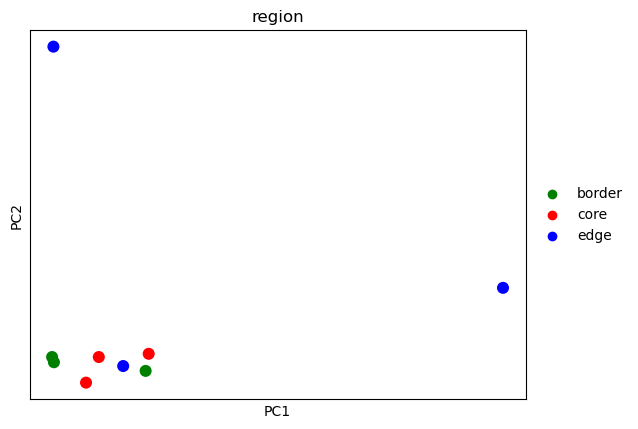

In [21]:
# Return raw counts to X
#dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)
sc.pl.pca(pdata, color=['region'], ncols=1, size=300,palette=['green', 'red', 'blue'] )

/group/neur6/singularity_imgs/.conda/envs/scvi-new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


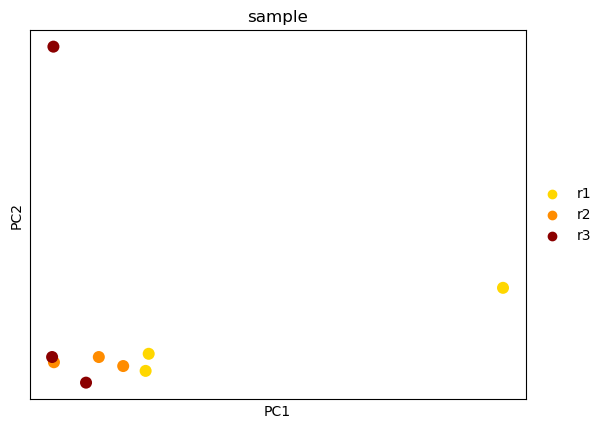

In [22]:
sc.pl.pca(pdata, color=['sample'], ncols=1, size=300,palette=[ 'gold','darkorange',
                                                                       'darkred'] )

In [23]:
pdata.obs['unit']=pdata.obs['region'].astype('str')+'_'+pdata.obs['sample'].astype('str')

In [24]:
pdata.obs['unit']=pdata.obs['unit'].astype('category')

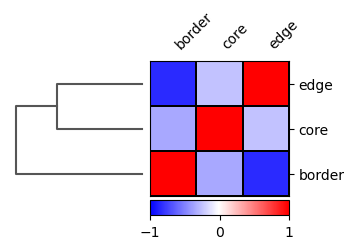

In [25]:
sc.pl.correlation_matrix(pdata,'region')

In [26]:
pdata=pdata[pdata.obs['region']!='edge']

/group/neur6/singularity_imgs/.conda/envs/scvi-new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/group/neur6/singularity_imgs/.conda/envs/scvi-new/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


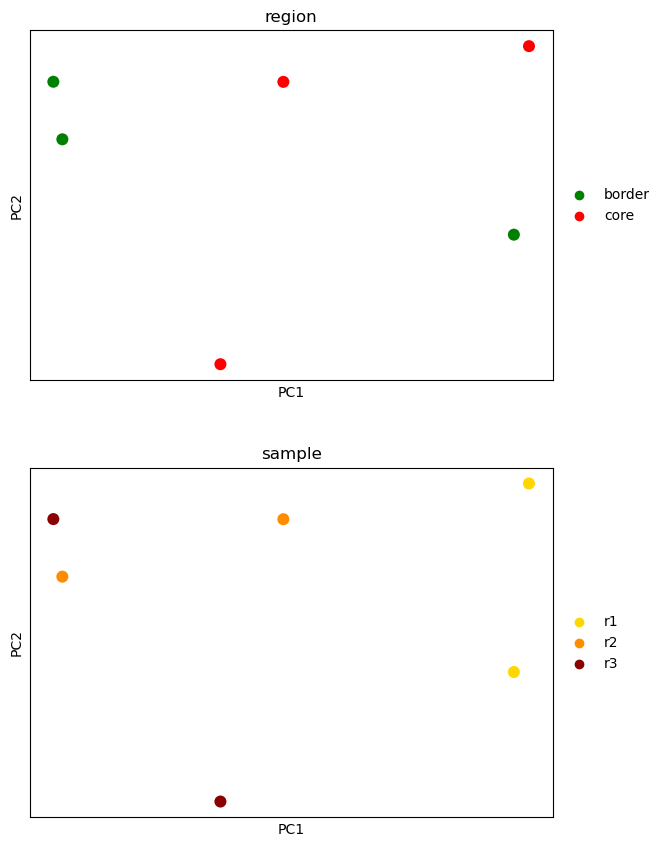

In [27]:
sc.pl.pca(pdata, color=['region','sample'], ncols=1, size=300)

In [60]:
pdata = dc.get_pseudobulk(
    adata_tot,
    sample_col='sample',
    groups_col='region',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)
pdata.layers['counts'] = pdata.X.copy()
from pydeseq2.dds import DeseqDataSet, DefaultInference

# Build DESeq2 object
inference = DefaulpdatInference(n_cpus=8)
dds = DeseqDataSet(
    adata=pdata,
    design_factors='region',
    ref_level=['region', 'border'],
    refit_cooks=False, inference=inference,
)

NameError: name 'DefaulpdatInference' is not defined

In [ ]:
# Compute LFCs
dds.deseq2()
stat_res = DeseqStats(
    dds,
    contrast=["region", 'core', 'border'],
    inference=inference,
)
# Compute Wald test
stat_res.summary()
results_df = stat_res.results_df
dc.plot_volcano_df(
    results_df,
    x='log2FoldChange',
    y='padj',
    top=20,
    figsize=(8, 4)
)

In [ ]:
results_df_adj=results_df[results_df['padj']<0.05]
results_core=results_df_adj[results_df_adj['log2FoldChange']>0]
results_core=results_core.sort_values(by='log2FoldChange',ascending=False)
results_core.index

In [ ]:
results_border=results_df_adj[results_df_adj['log2FoldChange']<0]
results_border=results_border.sort_values(by='log2FoldChange',ascending=True)
results_border.index

In [ ]:
progeny = dc.get_progeny(top=500)
progeny

In [ ]:
mat = results_df[['stat']].T.rename(index={'stat': 'core'})
mat

In [ ]:
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)
pathway_acts

In [ ]:
dc.plot_barplot(
    acts=pathway_acts,
    contrast='core',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

In [ ]:
dc.plot_targets(
    data=results_df,
    stat='stat',
    source_name='Hypoxia',
    net=progeny,
    top=15
)

In [ ]:
msigdb = dc.get_resource('MSigDB')
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

# Rename
msigdb.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in msigdb['geneset']]

enr_pvals = dc.get_ora_df(
    df=results_core,
    net=msigdb,
    source='geneset',
    target='genesymbol'
)

enr_pvals.head()


In [ ]:
dc.plot_dotplot(
    enr_pvals.sort_values('Combined score', ascending=False).head(15),
    x='Combined score',
    y='Term',
    s='Odds ratio',
    c='FDR p-value',
    scale=0.1,
    figsize=(3,6 )
)

# Plot
dc.plot_running_score(
    df=results_core,
    stat='stat',
    net=msigdb,
    source='geneset',
    target='genesymbol',
    set_name='HYPOXIA'
)

In [ ]:
x_median = adata_filtered_ctrl.obs['x'].median()

# Classify spots as 'left' or 'right' based on their x-coordinate
adata_filtered_ctrl.obs['side'] = np.where(adata_filtered_ctrl.obs['x'] <= x_median, 'left', 'right')

# Calculate mean gene expression for each side
left_expr = adata_filtered_ctrl[adata_filtered_ctrl.obs['side'] == 'left'].to_df().mean()
right_expr = adata_filtered_ctrl[adata_filtered_ctrl.obs['side'] == 'right'].to_df().mean()


In [30]:
pdata

AnnData object with n_obs × n_vars = 9 × 12888
    obs: 'orig.ident', 'is_outlier', 'region', 'sample', 'batch', 'psbulk_n_cells', 'psbulk_counts'
    var: 'n_cells-0', 'n_counts-0', 'mean_umi-0', 'n_cells-1', 'n_counts-1', 'mean_umi-1', 'n_cells-2', 'n_counts-2', 'mean_umi-2'
    layers: 'psbulk_props', 'counts'

In [31]:
adata_filtered_ctrl

AnnData object with n_obs × n_vars = 5443 × 12888
    obs: 'nCount_Spatial', 'percent.mito', 'nFeature_Spatial', 'orig.ident', 'x', 'y', 'distance_to_centroid', 'far_points', 'avg_neighbor_distance', 'neighbor_distance_zscore', 'is_outlier', 'distance_to_boundary', 'region', 'gene_expression', 'region_mean', 'region_mean_expression'
    var: 'n_cells', 'n_counts', 'mean_umi'
    uns: 'sn', 'region_colors'
    obsm: 'spatial'

In [32]:
pdata.obs['sample']

r1_border    r1
r2_border    r2
r3_border    r3
r1_core      r1
r2_core      r2
r3_core      r3
r1_edge      r1
r2_edge      r2
r3_edge      r3
Name: sample, dtype: object

In [33]:
pdata = dc.get_pseudobulk(
    adata_tot,
    sample_col='sample',
    groups_col='region',
    layer='counts',
    mode='sum',
    min_cells=0,
    min_counts=0
)
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)


In [8]:
pdatar1=pdata[pdata.obs['sample']=='r1']# Create a mapping from grouping variable to pseudobulk values
pdatar1
pseudobulk_df = pd.DataFrame(
    pdatar1.X.toarray() ,
    index=pdatar1.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar1.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df

A1BG  A1BG-AS1  A2ML1-AS1     A2MP1      AAAS      AACS     AADAT  \
border -0.343315 -0.669428   0.220542  0.639741 -0.041580 -0.631461 -0.070490   
core   -0.305891 -1.354709   2.052807 -0.666945 -0.010025  0.677743  1.699547   
edge   -1.376220  0.972348  -0.900683 -0.156450  0.208755 -0.700230  0.330373   

           AAGAB      AAK1     AAMDC  ...    ZSWIM9      ZUP1      ZW10  \
border  0.571922  0.725863 -1.173890  ...  0.964024 -0.124255  0.840745   
core    1.583273 -0.550935 -0.135231  ...  0.099401 -0.104148 -0.611834   
edge    1.262320  0.236024  1.798768  ... -1.374760  0.356709  1.035197   

          ZWILCH     ZWINT      ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1  
border -0.114740 -0.982990  0.983020 -0.467423  1.138125 -0.705168  0.058235  
core   -0.819903 -0.258722 -1.158769  0.430588  0.373856 -0.831479 -0.154284  
edge   -2.046041 -0.579184  1.703337 -0.975436  1.679745 -1.505910  2.071485  

[3 rows x 12888 columns]

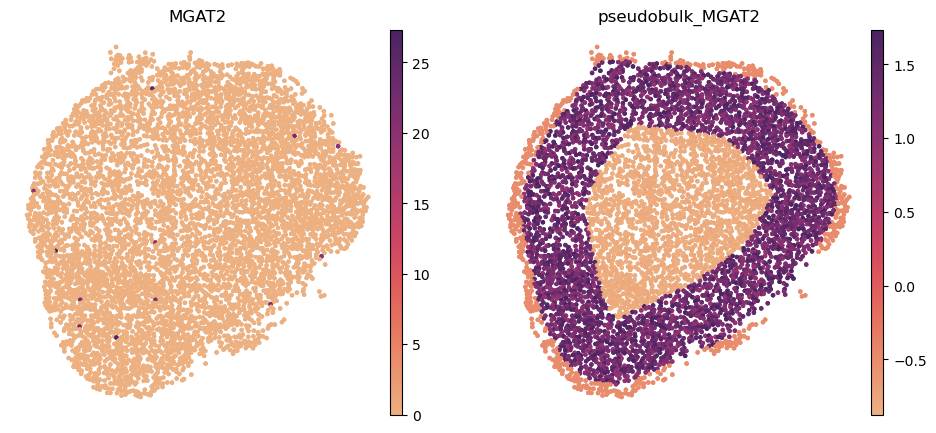

In [27]:
pdatar1=pdata[pdata.obs['sample']=='r1']# Create a mapping from grouping variable to pseudobulk values
pdatar1
pseudobulk_df = pd.DataFrame(
    pdatar1.X.toarray() ,
    index=pdatar1.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar1.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df
# Choose a gene of interest
gene = 'MGAT2'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_r1.obs[f'pseudobulk_{gene}'] = adata_r1.obs['region'].map(region_to_pseudobulk)
adata_r1.obs[f'pseudobulk_{gene}'].astype('float32')
#Add small variation to pseudobulk_GAPDH based on region
adata_r1.obs[f'pseudobulk_{gene}'] = adata_r1.obs.apply(
    lambda row: row[f'pseudobulk_{gene}'] + np.random.uniform(-0.05, 0.05) if row['region'] == 'core' else (
        row[f'pseudobulk_{gene}'] + np.random.uniform(-0.4, 0.4) if row['region'] == 'border' else row[f'pseudobulk_{gene}']
    ),
    axis=1
)

sq.pl.spatial_scatter(
    adata_r1,
    size=20,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[gene,f'pseudobulk_{gene}'],
    cmap='flare'
)

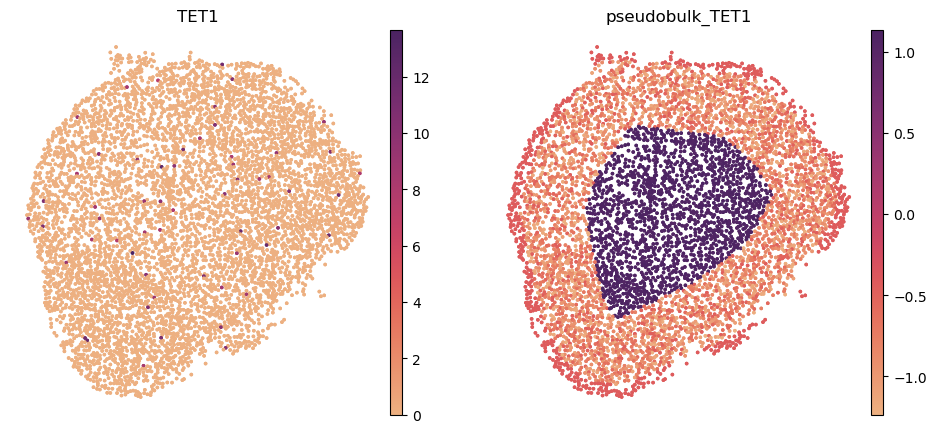

In [19]:
pdatar1=pdata[pdata.obs['sample']=='r1']# Create a mapping from grouping variable to pseudobulk values
pdatar1
pseudobulk_df = pd.DataFrame(
    pdatar1.X.toarray() ,
    index=pdatar1.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar1.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df
# Choose a gene of interest
gene = 'TET1'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_r1.obs[f'pseudobulk_{gene}'] = adata_r1.obs['region'].map(region_to_pseudobulk)
adata_r1.obs[f'pseudobulk_{gene}'].astype('float32')
#Add small variation to pseudobulk_GAPDH based on region
adata_r1.obs[f'pseudobulk_{gene}'] = adata_r1.obs.apply(
    lambda row: row[f'pseudobulk_{gene}'] + np.random.uniform(-0.05, 0.05) if row['region'] == 'core' else (
        row[f'pseudobulk_{gene}'] + np.random.uniform(-0.4, 0.4) if row['region'] == 'border' else row[f'pseudobulk_{gene}']
    ),
    axis=1
)

sq.pl.spatial_scatter(
    adata_r1,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[gene,f'pseudobulk_{gene}'],
    cmap='flare'
)

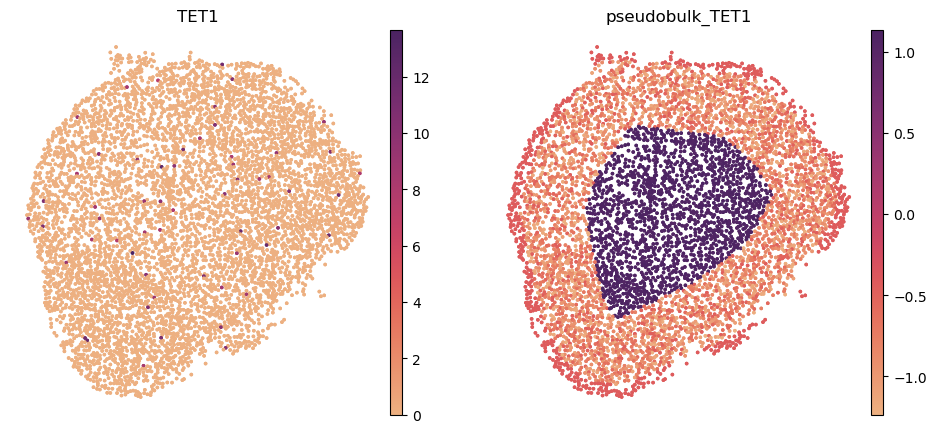

In [19]:
pdatar1=pdata[pdata.obs['sample']=='r1']# Create a mapping from grouping variable to pseudobulk values
pdatar1
pseudobulk_df = pd.DataFrame(
    pdatar1.X.toarray() ,
    index=pdatar1.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar1.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df
# Choose a gene of interest
gene = 'TET1'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_r1.obs[f'pseudobulk_{gene}'] = adata_r1.obs['region'].map(region_to_pseudobulk)
adata_r1.obs[f'pseudobulk_{gene}'].astype('float32')
#Add small variation to pseudobulk_GAPDH based on region
adata_r1.obs[f'pseudobulk_{gene}'] = adata_r1.obs.apply(
    lambda row: row[f'pseudobulk_{gene}'] + np.random.uniform(-0.05, 0.05) if row['region'] == 'core' else (
        row[f'pseudobulk_{gene}'] + np.random.uniform(-0.4, 0.4) if row['region'] == 'border' else row[f'pseudobulk_{gene}']
    ),
    axis=1
)

sq.pl.spatial_scatter(
    adata_r1,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[gene,f'pseudobulk_{gene}'],
    cmap='flare'
)

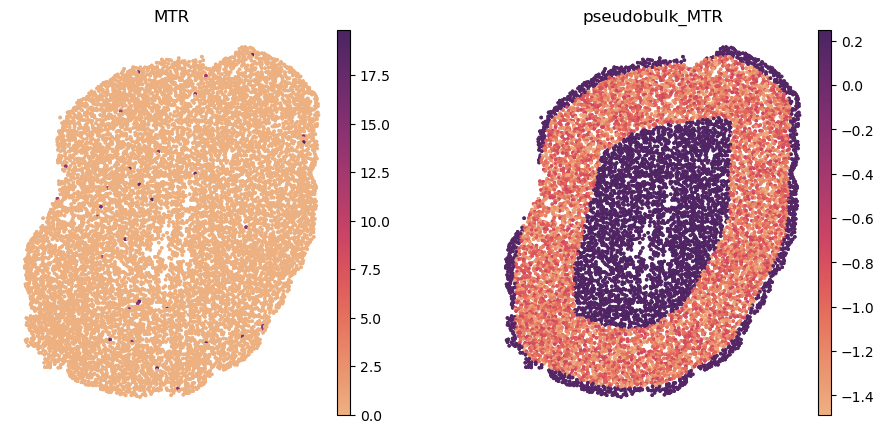

In [22]:
pdatar2=pdata[pdata.obs['sample']=='r2']# Create a mapping from grouping variable to pseudobulk values
pdatar2
pseudobulk_df = pd.DataFrame(
    pdatar2.X.toarray() ,
    index=pdatar2.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar2.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df
# Choose a gene of interest
gene = 'MTR'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_r2.obs[f'pseudobulk_{gene}'] = adata_r2.obs['region'].map(region_to_pseudobulk)
adata_r2.obs[f'pseudobulk_{gene}'].astype('float32')
#Add small variation to pseudobulk_GAPDH based on region
adata_r2.obs[f'pseudobulk_{gene}'] = adata_r2.obs.apply(
    lambda row: row[f'pseudobulk_{gene}'] + np.random.uniform(-0.05, 0.05) if row['region'] == 'core' else (
        row[f'pseudobulk_{gene}'] + np.random.uniform(-0.4, 0.4) if row['region'] == 'border' else row[f'pseudobulk_{gene}']
    ),
    axis=1
)

sq.pl.spatial_scatter(
    adata_r2,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[gene,f'pseudobulk_{gene}'],
    cmap='flare'
)

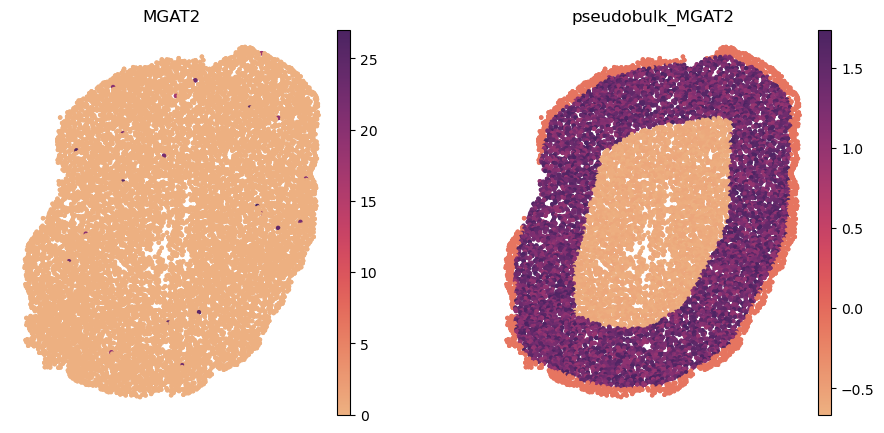

In [28]:
pdatar2=pdata[pdata.obs['sample']=='r2']# Create a mapping from grouping variable to pseudobulk values
pdatar2
pseudobulk_df = pd.DataFrame(
    pdatar2.X.toarray() ,
    index=pdatar2.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar2.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df
# Choose a gene of interest
gene = 'MGAT2'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_r2.obs[f'pseudobulk_{gene}'] = adata_r2.obs['region'].map(region_to_pseudobulk)
adata_r2.obs[f'pseudobulk_{gene}'].astype('float32')
#Add small variation to pseudobulk_GAPDH based on region
adata_r2.obs[f'pseudobulk_{gene}'] = adata_r2.obs.apply(
    lambda row: row[f'pseudobulk_{gene}'] + np.random.uniform(-0.05, 0.05) if row['region'] == 'core' else (
        row[f'pseudobulk_{gene}'] + np.random.uniform(-0.4, 0.4) if row['region'] == 'border' else row[f'pseudobulk_{gene}']
    ),
    axis=1
)

sq.pl.spatial_scatter(
    adata_r2,
    size=20,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[gene,f'pseudobulk_{gene}'],
    cmap='flare'
)

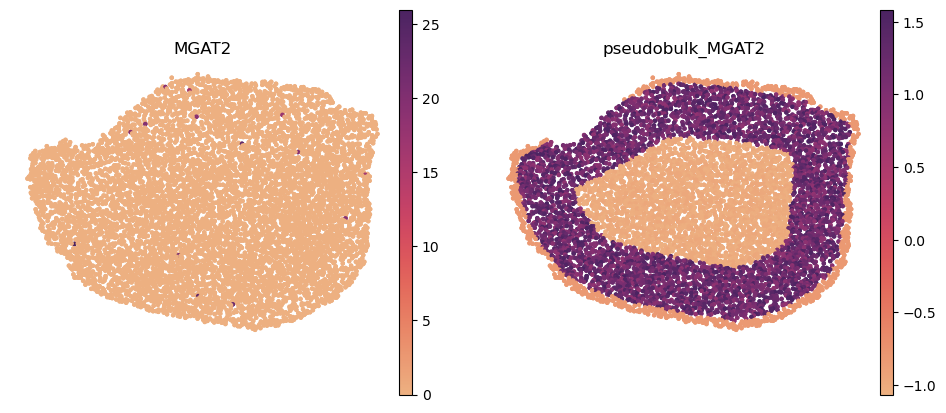

In [31]:
pdatar3=pdata[pdata.obs['sample']=='r3']# Create a mapping from grouping variable to pseudobulk values
pdatar3
pseudobulk_df = pd.DataFrame(
    pdatar3.X.toarray() ,
    index=pdatar3.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar3.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df
# Choose a gene of interest
gene = 'MGAT2'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_r3.obs[f'pseudobulk_{gene}'] = adata_r3.obs['region'].map(region_to_pseudobulk)
adata_r3.obs[f'pseudobulk_{gene}'].astype('float32')
#Add small variation to pseudobulk_GAPDH based on region
adata_r3.obs[f'pseudobulk_{gene}'] = adata_r3.obs.apply(
    lambda row: row[f'pseudobulk_{gene}'] + np.random.uniform(-0.05, 0.05) if row['region'] == 'core' else (
        row[f'pseudobulk_{gene}'] + np.random.uniform(-0.4, 0.4) if row['region'] == 'border' else row[f'pseudobulk_{gene}']
    ),
    axis=1
)

sq.pl.spatial_scatter(
    adata_r3,
    size=20,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[gene,f'pseudobulk_{gene}'],
    cmap='flare'
)

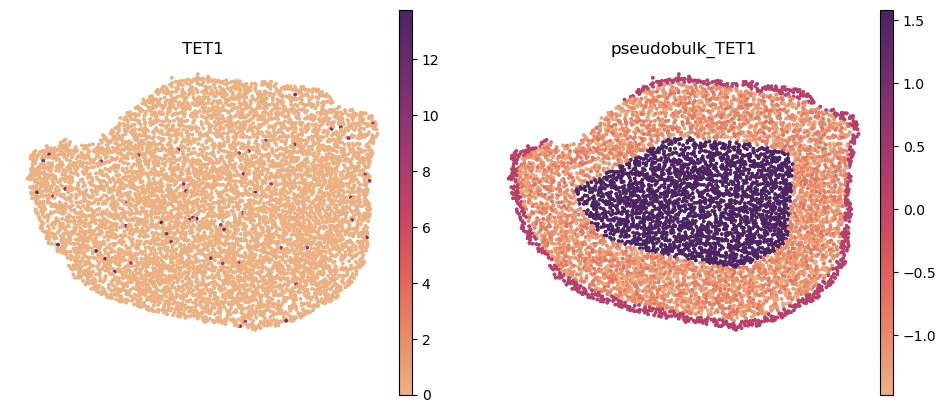

In [20]:
pdatar3=pdata[pdata.obs['sample']=='r2']# Create a mapping from grouping variable to pseudobulk values
pdatar3
pseudobulk_df = pd.DataFrame(
    pdatar3.X.toarray() ,
    index=pdatar3.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar3.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df
# Choose a gene of interest
gene = 'TET1'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_r3.obs[f'pseudobulk_{gene}'] = adata_r3.obs['region'].map(region_to_pseudobulk)
adata_r3.obs[f'pseudobulk_{gene}'].astype('float32')
#Add small variation to pseudobulk_GAPDH based on region
adata_r3.obs[f'pseudobulk_{gene}'] = adata_r3.obs.apply(
    lambda row: row[f'pseudobulk_{gene}'] + np.random.uniform(-0.05, 0.05) if row['region'] == 'core' else (
        row[f'pseudobulk_{gene}'] + np.random.uniform(-0.4, 0.4) if row['region'] == 'border' else row[f'pseudobulk_{gene}']
    ),
    axis=1
)

sq.pl.spatial_scatter(
    adata_r3,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[gene,f'pseudobulk_{gene}'],
    cmap='flare'
)

In [9]:
# Choose a gene of interest
gene = 'GAPDH'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_filtered_ctrl.obs[f'pseudobulk_{gene}'] = adata_filtered_ctrl.obs['region'].map(region_to_pseudobulk)
adata_filtered_ctrl.obs[f'pseudobulk_{gene}'].astype('float32')
sq.pl.spatial_scatter(
    adata_filtered_ctrl,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=["pseudobulk_GAPDH"],
    cmap='Blues'
)

NameError: name 'adata_filtered_ctrl' is not defined

/group/neur6/singularity_imgs/.conda/envs/scvi-new/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:981: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


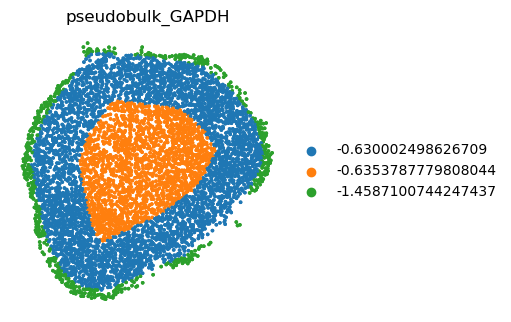

In [54]:
# Choose a gene of interest
gene = 'PAM'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_filtered_ctrl.obs[f'pseudobulk_{gene}'] = adata_filtered_ctrl.obs['region'].map(region_to_pseudobulk)
adata_filtered_ctrl.obs[f'pseudobulk_{gene}'].astype('float32')


sq.pl.spatial_scatter(
    adata_filtered_ctrl,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=["pseudobulk_GAPDH"],
    cmap='Blues'
)

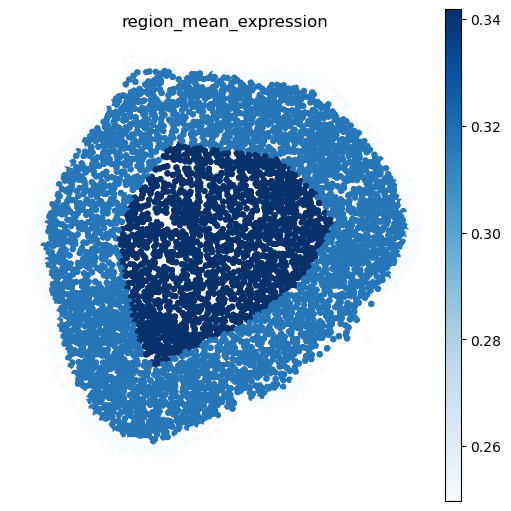

In [36]:

adata_filtered_ctrl.obs['gene_expression'] = adata_filtered_ctrl[:, 'GAPDH'].X.toarray().flatten()
# Assuming 'gene_expression' contains the expression levels of your gene
mean_expression_per_region = adata_filtered_ctrl.obs.groupby('region')['gene_expression'].mean()
# Map the mean expression to each spot based on its region
adata_filtered_ctrl.obs['region_mean']=adata_filtered_ctrl.obs['region']
adata_filtered_ctrl.obs['region_mean_expression'] = adata_filtered_ctrl.obs['region_mean'].map(mean_expression_per_region)
adata_filtered_ctrl.obs['region_mean_expression']=adata_filtered_ctrl.obs['region_mean_expression'].astype('float32')
sq.pl.spatial_scatter(
    adata_filtered_ctrl,
    size=50,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=["region_mean_expression"],
    cmap='Blues'
)


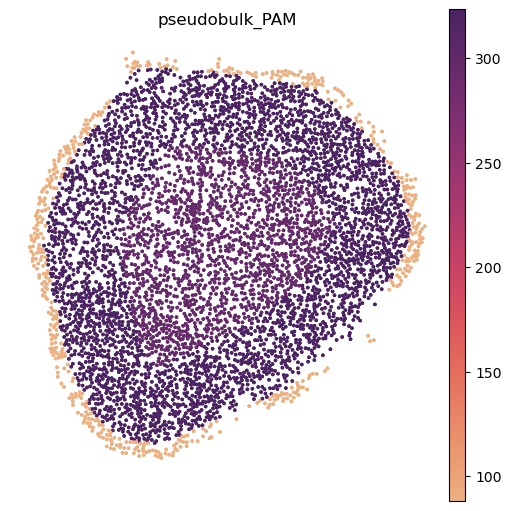

In [55]:
pdatar1=pdata[pdata.obs['sample']=='r1']# Create a mapping from grouping variable to pseudobulk values
pdatar1
pseudobulk_df = pd.DataFrame(
    pdatar1.X.toarray() ,
    index=pdatar1.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar1.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df


gene = 'PAM'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_filtered_ctrl.obs[f'pseudobulk_{gene}'] = adata_filtered_ctrl.obs['region'].map(region_to_pseudobulk)
adata_filtered_ctrl.obs[f'pseudobulk_{gene}'].astype('float32')

#Add small variation to pseudobulk_GAPDH based on region
adata_filtered_ctrl.obs[f'pseudobulk_{gene}'] = adata_filtered_ctrl.obs.apply(
    lambda row: row[f'pseudobulk_{gene}'] + np.random.uniform(-0.05, 0.05) if row['region'] == 'core' else (
        row[f'pseudobulk_{gene}'] + np.random.uniform(-0.4, 0.4) if row['region'] == 'border' else row[f'pseudobulk_{gene}']
    ),
    axis=1
)

sq.pl.spatial_scatter(
    adata_filtered_ctrl,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[f'pseudobulk_{gene}'],
    cmap='flare'
)

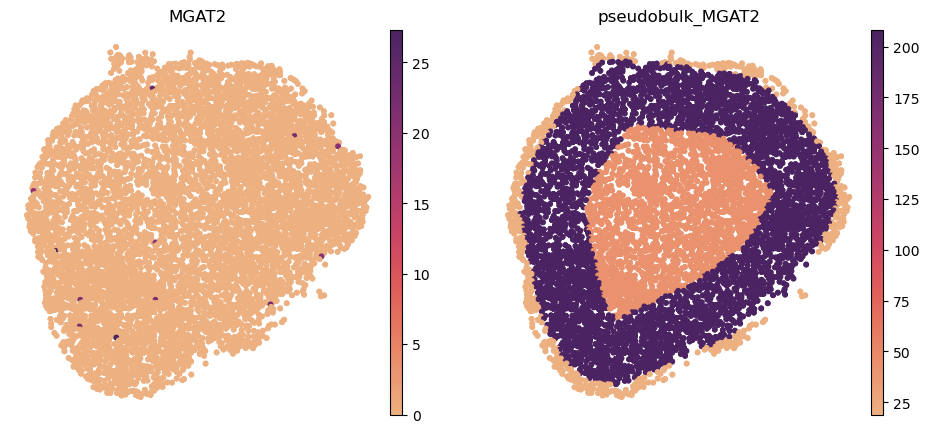

In [73]:
pdatar1=pdata[pdata.obs['sample']=='r1']# Create a mapping from grouping variable to pseudobulk values
pdatar1
pseudobulk_df = pd.DataFrame(
    pdatar1.X.toarray() ,
    index=pdatar1.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar1.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df


gene = 'MGAT2'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_filtered_ctrl.obs[f'pseudobulk_{gene}'] = adata_filtered_ctrl.obs['region'].map(region_to_pseudobulk)
adata_filtered_ctrl.obs[f'pseudobulk_{gene}'].astype('float32')

#Add small variation to pseudobulk_GAPDH based on region
adata_filtered_ctrl.obs[f'pseudobulk_{gene}'] = adata_filtered_ctrl.obs.apply(
    lambda row: row[f'pseudobulk_{gene}'] + np.random.uniform(-0.05, 0.05) if row['region'] == 'core' else (
        row[f'pseudobulk_{gene}'] + np.random.uniform(-0.4, 0.4) if row['region'] == 'border' else row[f'pseudobulk_{gene}']
    ),
    axis=1
)

sq.pl.spatial_scatter(
    adata_filtered_ctrl,
    size=40,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[gene,f'pseudobulk_{gene}'],
    cmap='flare'
)

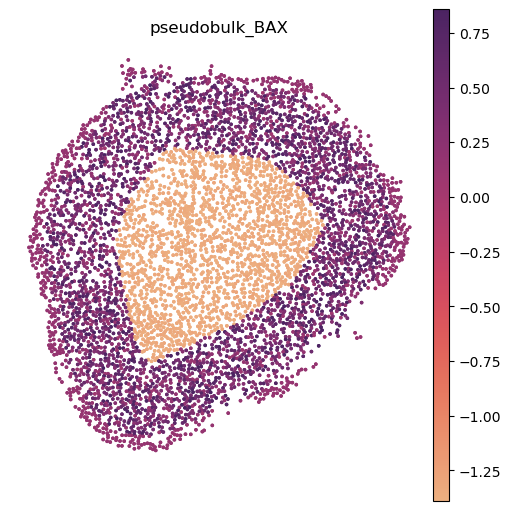

In [47]:
pdatar1=pdata[pdata.obs['sample']=='r1']# Create a mapping from grouping variable to pseudobulk values
pdatar1
pseudobulk_df = pd.DataFrame(
    pdatar1.X.toarray() ,
    index=pdatar1.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar1.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df


gene = 'BAX'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_filtered_ctrl.obs[f'pseudobulk_{gene}'] = adata_filtered_ctrl.obs['region'].map(region_to_pseudobulk)
adata_filtered_ctrl.obs[f'pseudobulk_{gene}'].astype('float32')

#Add small variation to pseudobulk_GAPDH based on region
adata_filtered_ctrl.obs[f'pseudobulk_{gene}'] = adata_filtered_ctrl.obs.apply(
    lambda row: row[f'pseudobulk_{gene}'] + np.random.uniform(-0.05, 0.05) if row['region'] == 'core' else (
        row[f'pseudobulk_{gene}'] + np.random.uniform(-0.4, 0.4) if row['region'] == 'border' else row[f'pseudobulk_{gene}']
    ),
    axis=1
)

sq.pl.spatial_scatter(
    adata_filtered_ctrl,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[f'pseudobulk_{gene}'],
    cmap='flare'
)

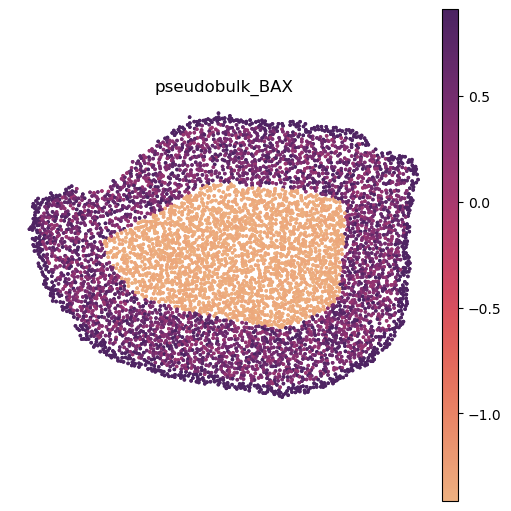

In [46]:
pdatar3=pdata[pdata.obs['sample']=='r3']# Create a mapping from grouping variable to pseudobulk values
pdatar3
pseudobulk_df = pd.DataFrame(
    pdatar3.X.toarray() ,
    index=pdatar3.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar3.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df


gene = 'BAX'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_filtered.obs[f'pseudobulk_{gene}'] = adata_filtered.obs['region'].map(region_to_pseudobulk)
adata_filtered.obs[f'pseudobulk_{gene}'].astype('float32')

# Add small variation to pseudobulk_GAPDH based on region
adata_filtered.obs[f'pseudobulk_{gene}'] = adata_filtered.obs.apply(
   lambda row: row[f'pseudobulk_{gene}'] + np.random.uniform(-0.05, 0.05) if row['region'] == 'core' else (
        row[f'pseudobulk_{gene}'] + np.random.uniform(-0.4, 0.4) if row['region'] == 'border' else row[f'pseudobulk_{gene}']
    ),
    axis=1
)

sq.pl.spatial_scatter(
    adata_filtered,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[f'pseudobulk_{gene}'],
    cmap='flare'
)

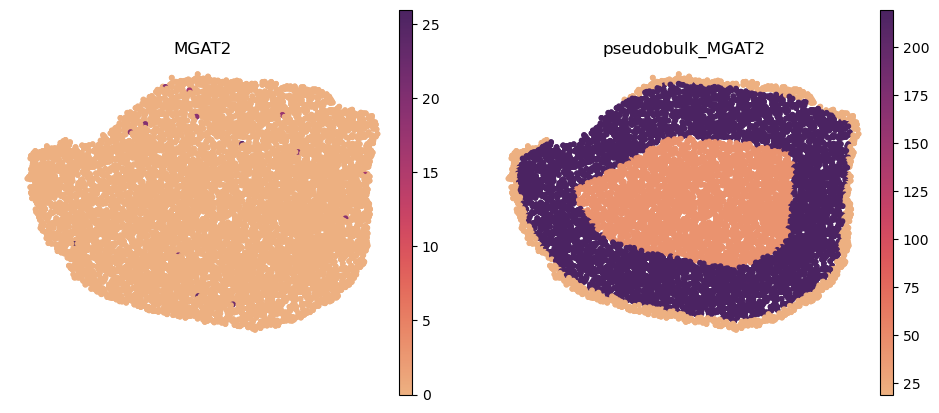

In [72]:
pdatar3=pdata[pdata.obs['sample']=='r3']# Create a mapping from grouping variable to pseudobulk values
pdatar3
pseudobulk_df = pd.DataFrame(
    pdatar3.X.toarray() ,
    index=pdatar3.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar3.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df


gene = 'MGAT2'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_filtered.obs[f'pseudobulk_{gene}'] = adata_filtered.obs['region'].map(region_to_pseudobulk)
adata_filtered.obs[f'pseudobulk_{gene}'].astype('float32')

# Add small variation to pseudobulk_GAPDH based on region
adata_filtered.obs[f'pseudobulk_{gene}'] = adata_filtered.obs.apply(
   lambda row: row[f'pseudobulk_{gene}'] + np.random.uniform(-0.05, 0.05) if row['region'] == 'core' else (
        row[f'pseudobulk_{gene}'] + np.random.uniform(-0.4, 0.4) if row['region'] == 'border' else row[f'pseudobulk_{gene}']
    ),
    axis=1
)

sq.pl.spatial_scatter(
    adata_filtered,
    size=40,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[gene,f'pseudobulk_{gene}'],
    cmap='flare'
)

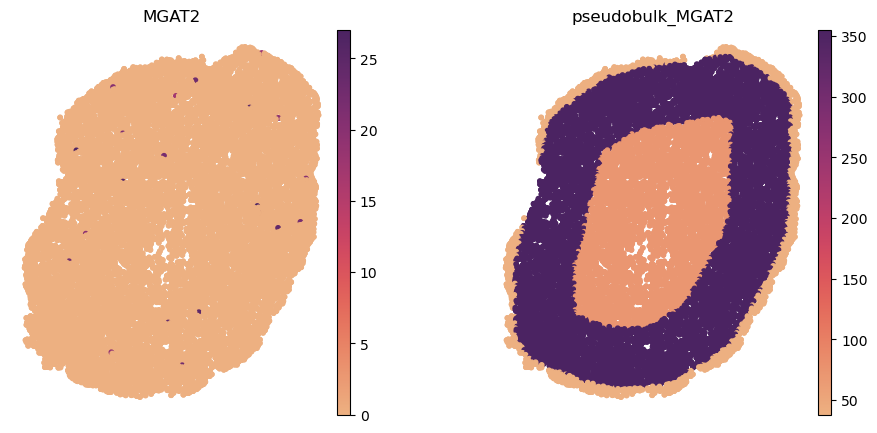

In [70]:
pdatar2=pdata[pdata.obs['sample']=='r2']# Create a mapping from grouping variable to pseudobulk values
pdatar2
pseudobulk_df = pd.DataFrame(
    pdatar2.X.toarray() ,
    index=pdatar2.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar2.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df


gene = 'MGAT2'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_filtered_hetero.obs[f'pseudobulk_{gene}'] = adata_filtered_hetero.obs['region'].map(region_to_pseudobulk)
adata_filtered_hetero.obs[f'pseudobulk_{gene}'].astype('float32')

# Add small variation to pseudobulk_GAPDH based on region
adata_filtered_hetero.obs[f'pseudobulk_{gene}'] = adata_filtered_hetero.obs.apply(
   lambda row: row[f'pseudobulk_{gene}'] + np.random.uniform(-0.05, 0.05) if row['region'] == 'core' else (
        row[f'pseudobulk_{gene}'] + np.random.uniform(-0.4, 0.4) if row['region'] == 'border' else row[f'pseudobulk_{gene}']
    ),
    axis=1
)

sq.pl.spatial_scatter(
    adata_filtered_hetero,
    size=40,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[gene,f'pseudobulk_{gene}'],
    cmap='flare'
)

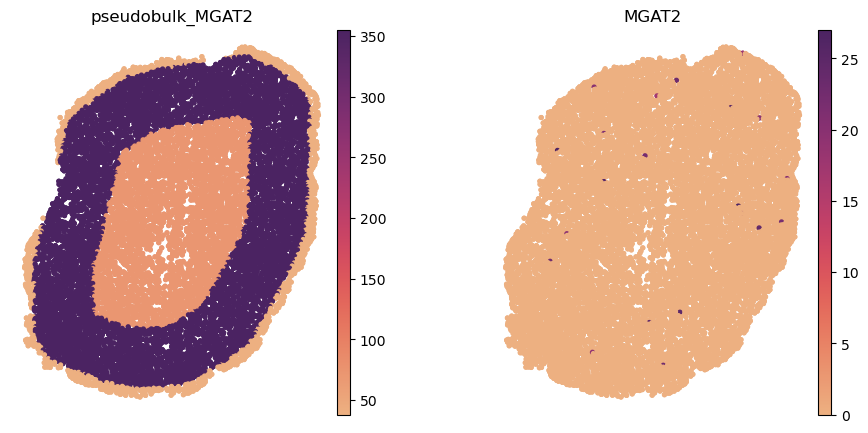

In [68]:

sq.pl.spatial_scatter(
    adata_filtered_hetero,
    size=30,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[f'pseudobulk_{gene}',gene],
    cmap='flare'
)

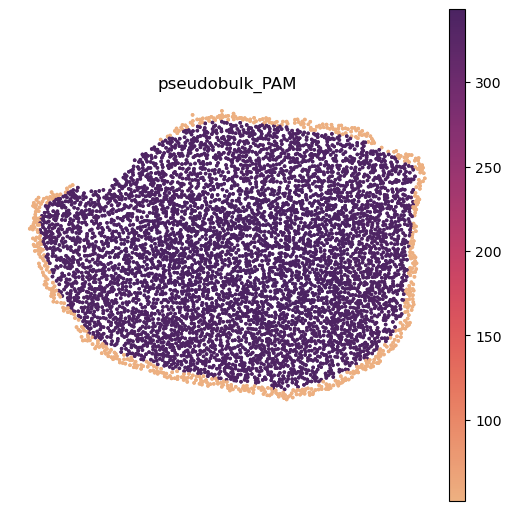

In [56]:
pdatar3=pdata[pdata.obs['sample']=='r3']# Create a mapping from grouping variable to pseudobulk values
pdatar3
pseudobulk_df = pd.DataFrame(
    pdatar3.X.toarray() ,
    index=pdatar3.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar3.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df


gene = 'PAM'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_filtered.obs[f'pseudobulk_{gene}'] = adata_filtered.obs['region'].map(region_to_pseudobulk)
adata_filtered.obs[f'pseudobulk_{gene}'].astype('float32')

# Add small variation to pseudobulk_GAPDH based on region
adata_filtered.obs[f'pseudobulk_{gene}'] = adata_filtered.obs.apply(
   lambda row: row[f'pseudobulk_{gene}'] + np.random.uniform(-0.05, 0.05) if row['region'] == 'core' else (
        row[f'pseudobulk_{gene}'] + np.random.uniform(-0.4, 0.4) if row['region'] == 'border' else row[f'pseudobulk_{gene}']
    ),
    axis=1
)

sq.pl.spatial_scatter(
    adata_filtered,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[f'pseudobulk_{gene}'],
    cmap='flare'
)

KeyError: 'Could not find key pseudobulk_VDAC3 in .var_names or .obs.columns.'

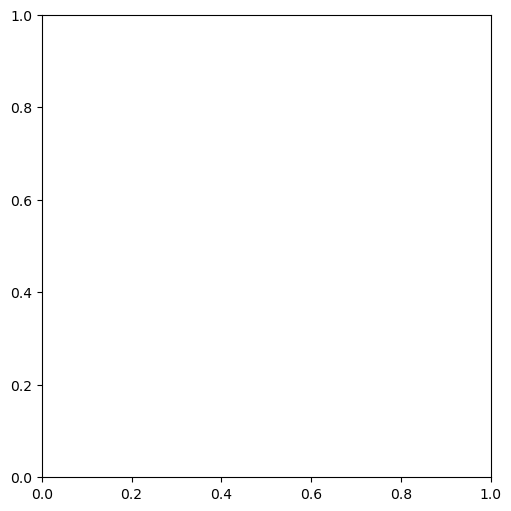

In [59]:
pdatar2=pdata[pdata.obs['sample']=='r2']# Create a mapping from grouping variable to pseudobulk values
pdatar2
pseudobulk_df = pd.DataFrame(
    pdatar2.X.toarray() ,
    index=pdatar2.obs_names,       # Use sample/region identifiers from pdata.obs
    columns=pdatar2.var_names      # Gene names from pdata.var
)
pseudobulk_df.index=['border','core','edge']
pseudobulk_df


gene = 'VDAC3'  # Replace with your gene name


# Create a mapping from region to pseudobulk values for the selected gene
region_to_pseudobulk = pseudobulk_df[gene]

# Map the pseudobulk values onto adata.obs based on the region
adata_filtered_hetero.obs[f'pseudobulk_{gene}'] = adata_filtered_hetero.obs['region'].map(region_to_pseudobulk)
adata_filtered_hetero.obs[f'pseudobulk_{gene}'].astype('float32')

# Add small variation to pseudobulk_GAPDH based on region
adata_filtered_hetero.obs[f'pseudobulk_{gene}'] = adata_filtered_hetero.obs.apply(
    lambda row: row[f'pseudobulk_{gene}'] + np.random.uniform(-0.01, 0.01) if row['region'] == 'core' else (
        row[f'pseudobulk_{gene}'] + np.random.uniform(-0.1, 0.1) if row['region'] == 'border' else row[f'pseudobulk_{gene}']
    ),
    axis=1
)

sq.pl.spatial_scatter(
    adata_filtered,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[f'pseudobulk_{gene}'],
    cmap='flare'
)

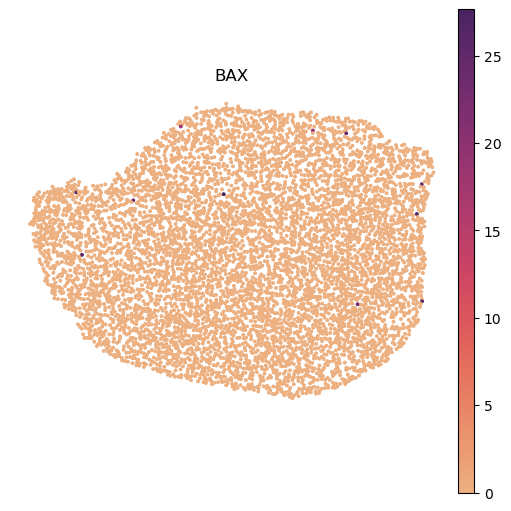

In [40]:
sq.pl.spatial_scatter(
    adata_filtered,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[gene],
    cmap='flare'
)

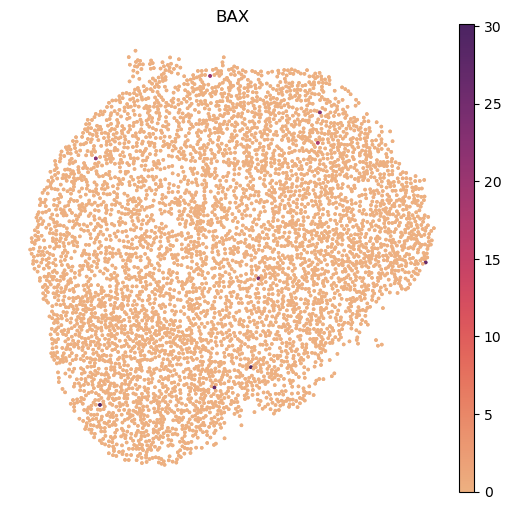

In [49]:
sq.pl.spatial_scatter(
    adata_filtered_ctrl,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[gene],
    cmap='flare'
)

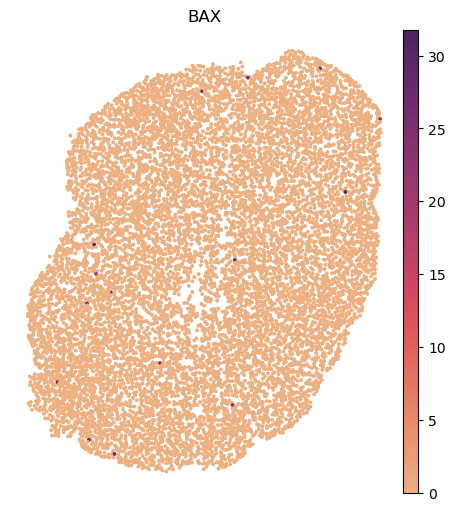

In [51]:
sq.pl.spatial_scatter(
    adata_filtered_hetero,
    size=10,
    library_id="spatial",
    figsize=(5, 5),
    ncols=2,
    frameon=False,
    shape=None,
    color=[gene],
    cmap='flare'
)